In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score

from tcn import TCN, tcn_full_summary

import warnings
warnings.filterwarnings("ignore")

huwaei=pd.read_csv('training_100.csv')
huwaei['timestamp']=pd.to_datetime(huwaei['timestamp'])
huwaei

2022-11-06 12:04:52.942705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,timestamp,kpi_value,request_count,anomaly_label
0,2020-08-14 02:00:00+02:00,0.998755,24908,0
1,2020-08-14 02:01:00+02:00,0.997683,25029,0
2,2020-08-14 02:02:00+02:00,0.998341,24115,0
3,2020-08-14 02:03:00+02:00,0.998211,24031,0
4,2020-08-14 02:04:00+02:00,0.998403,23790,0
...,...,...,...,...
20154,2020-08-28 01:56:00+02:00,0.998149,26467,0
20155,2020-08-28 01:57:00+02:00,0.998340,26502,0
20156,2020-08-28 01:58:00+02:00,0.998364,26887,0
20157,2020-08-28 01:59:00+02:00,0.998428,26712,0


In [2]:
max_features=4
x=huwaei['kpi_value']
t=huwaei['timestamp']
label=huwaei['anomaly_label']

Text(0.5, 1.0, 'Huwaei Dataset')

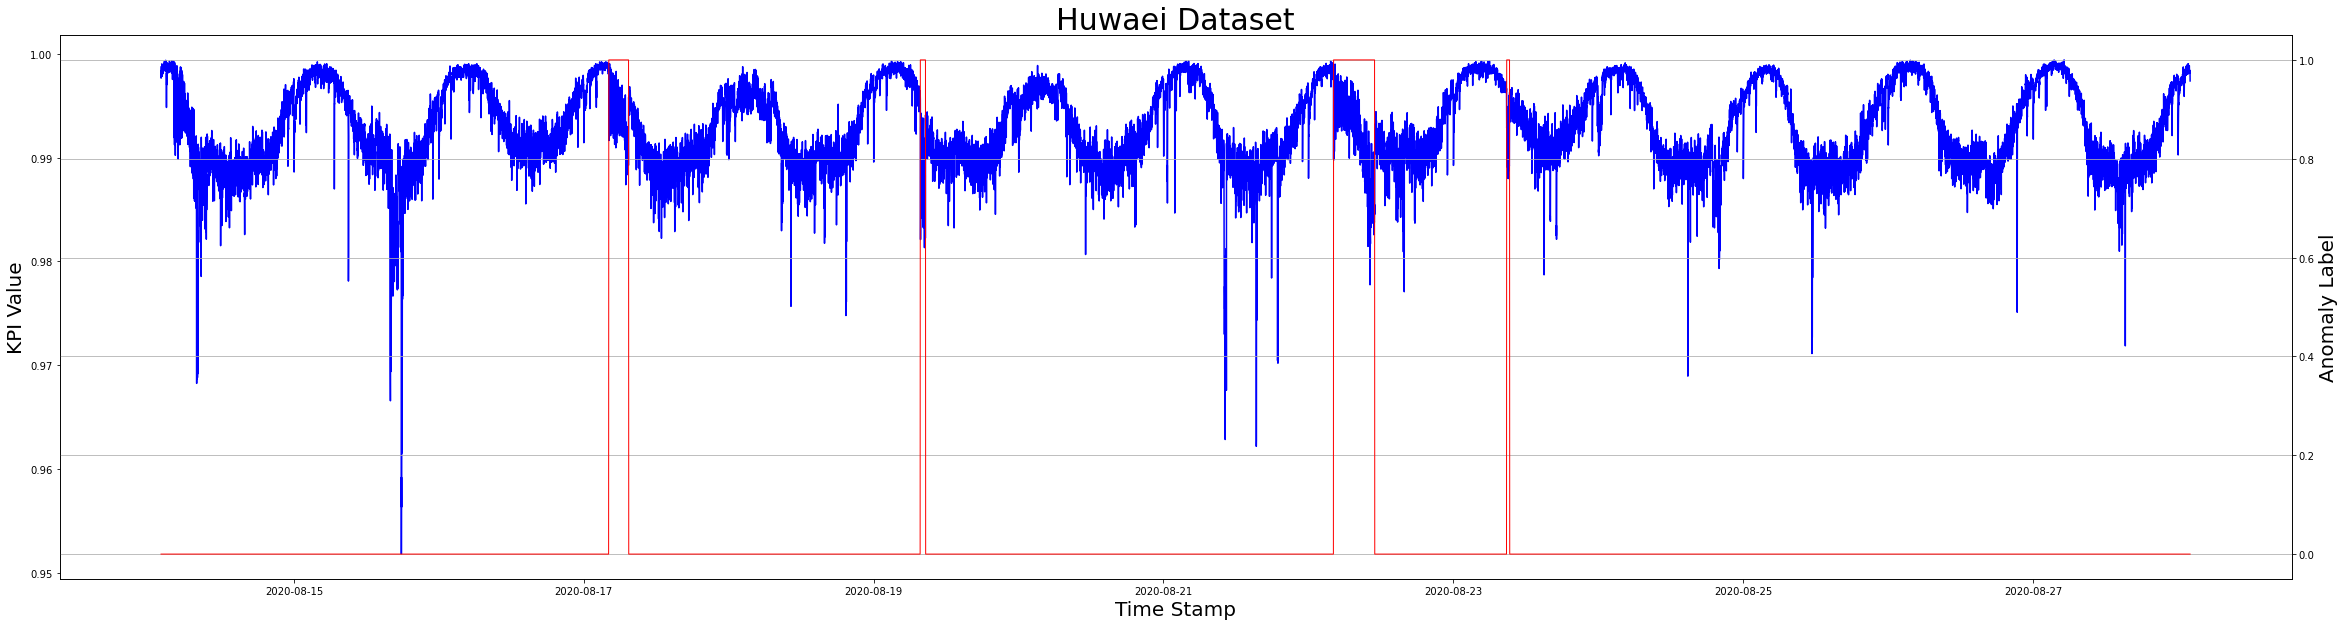

In [3]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(t, x, color='blue')
ax2a.plot(t, label, color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

Start date is:  2020-08-14 02:00:00+02:00
End date is:  2020-08-28 02:00:00+02:00
Length of full data: 20159


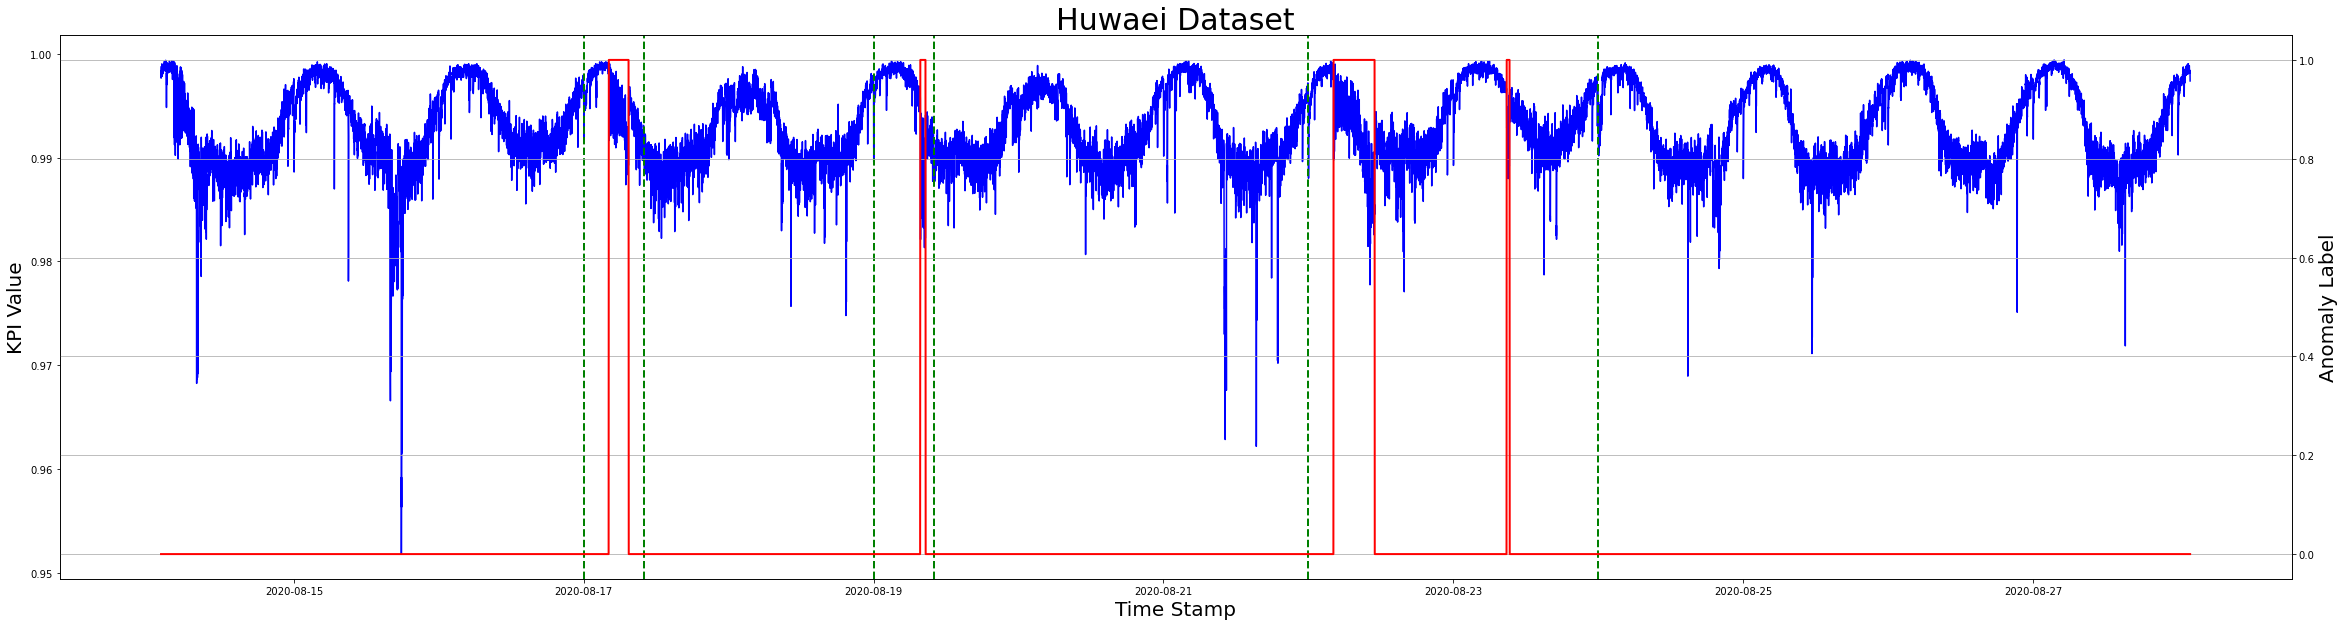

In [4]:
split1=t[4200]
split2=t[4800]
split3=t[7080]
split4=t[7680]
split5=t[11400]
split6=t[14280]

fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(t, x, color='blue')
ax2a.plot(t, label, color='red', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6, color='green', linestyle='dashed', linewidth='2')


plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

print("Start date is: ", t.min())
print("End date is: ", t.max())
print(f"Length of full data: {len(huwaei)}")

In [5]:
splits=[split1, split2, split3, split4, split5, split6]
splits

[Timestamp('2020-08-17 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-17 10:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-19 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-19 10:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-22 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-24 00:00:00+0200', tz='pytz.FixedOffset(120)')]

Text(0.5, 1.0, 'Huwaei Dataset')

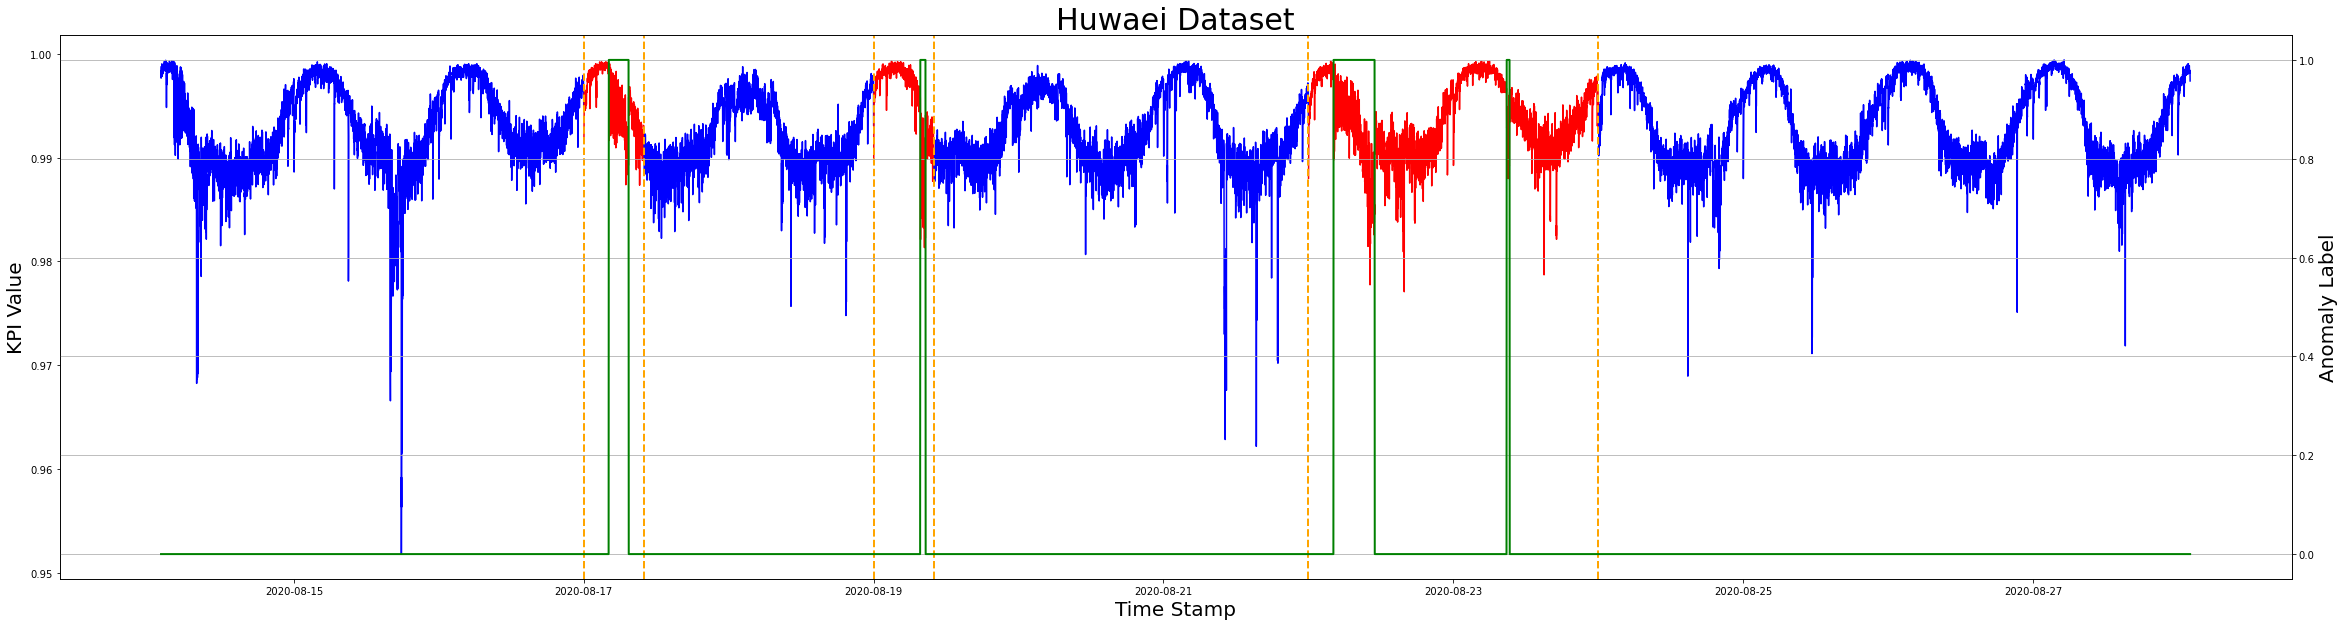

In [6]:
# Training intervals
train1 = huwaei.loc[t <= splits[0]]

train2 = huwaei.loc[(t > splits[1]) & (t <= splits[2])]

train3 = huwaei.loc[(t > splits[3]) & (t <= splits[4])]

train4 = huwaei.loc[t > splits[5]]


# Testing intervals
test1 = huwaei.loc[(t > splits[0]) & (t <= splits[1])]

test2 = huwaei.loc[(t > splits[2]) & (t <= splits[3])]

test3 = huwaei.loc[(t > splits[4]) & (t <= splits[5])]

fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(train1['timestamp'], train1['kpi_value'], color='blue')
ax2d.plot(test1['timestamp'], test1['kpi_value'], color='red')
ax2d.plot(train2['timestamp'], train2['kpi_value'], color='blue')
ax2d.plot(test2['timestamp'], test2['kpi_value'], color='red')
ax2d.plot(train3['timestamp'], train3['kpi_value'], color='blue')
ax2d.plot(test3['timestamp'], test3['kpi_value'], color='red')
ax2d.plot(train4['timestamp'], train4['kpi_value'], color='blue')
ax2a.plot(t, label, color='green', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split2, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split3, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split4, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split5, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split6, color='orange', linestyle='dashed', linewidth='2')

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

In [7]:
# Preprocessing: normalize the data in mean and variance
scaler = StandardScaler()
scaler = scaler.fit(pd.concat([train1, train2, train3, train4])[['kpi_value', 'request_count']]) #To normalize the mean and variance

train1[['kpi_value', 'request_count']] = scaler.transform(train1[['kpi_value', 'request_count']])
train2[['kpi_value', 'request_count']] = scaler.transform(train2[['kpi_value', 'request_count']])
train3[['kpi_value', 'request_count']] = scaler.transform(train3[['kpi_value', 'request_count']])
train4[['kpi_value', 'request_count']] = scaler.transform(train4[['kpi_value', 'request_count']])

trainSeqs = [train1, train2, train3, train4]

# Avoid leakage of information between train and test dataset

test1[['kpi_value', 'request_count']] = scaler.transform(test1[['kpi_value', 'request_count']])
test2[['kpi_value', 'request_count']] = scaler.transform(test2[['kpi_value', 'request_count']])
test3[['kpi_value', 'request_count']] = scaler.transform(test3[['kpi_value', 'request_count']])

testSeqs = [test1, test2, test3]

# Compute the train to test ratio

learn_ratio = pd.concat(trainSeqs).shape[0] / huwaei.shape[0]
print("Learn dataset percentage: " "{:.2f}" "%".format(learn_ratio*100))

test_ratio = pd.concat(testSeqs).shape[0] / huwaei.shape[0]
print("Learn dataset percentage: " "{:.2f}" "%".format(test_ratio*100))

Learn dataset percentage: 79.76%
Learn dataset percentage: 20.24%


In [8]:
trainSeqs

[                     timestamp  kpi_value  request_count  anomaly_label
 0    2020-08-14 02:00:00+02:00   1.508552       1.765505              0
 1    2020-08-14 02:01:00+02:00   1.243159       1.783991              0
 2    2020-08-14 02:02:00+02:00   1.406095       1.644353              0
 3    2020-08-14 02:03:00+02:00   1.373775       1.631520              0
 4    2020-08-14 02:04:00+02:00   1.421287       1.594701              0
 ...                        ...        ...            ...            ...
 4196 2020-08-16 23:56:00+02:00   1.164309       1.031870              0
 4197 2020-08-16 23:57:00+02:00   1.160132       1.069912              0
 4198 2020-08-16 23:58:00+02:00   1.081624       0.943412              0
 4199 2020-08-16 23:59:00+02:00   1.086746       0.860760              0
 4200 2020-08-17 00:00:00+02:00   0.492590       9.208951              0
 
 [4201 rows x 4 columns],
                      timestamp  kpi_value  request_count  anomaly_label
 4801 2020-08-17 10:01:

In [9]:
testSeqs

[                     timestamp  kpi_value  request_count  anomaly_label
 4201 2020-08-17 00:01:00+02:00  -0.298217       4.215895              0
 4202 2020-08-17 00:02:00+02:00  -0.174642       2.022476              0
 4203 2020-08-17 00:03:00+02:00   0.387258       1.556812              0
 4204 2020-08-17 00:04:00+02:00   0.446124       1.490659              0
 4205 2020-08-17 00:05:00+02:00   0.582078       1.358966              0
 ...                        ...        ...            ...            ...
 4796 2020-08-17 09:56:00+02:00  -0.072083      -0.438761              0
 4797 2020-08-17 09:57:00+02:00  -0.350213      -0.522177              0
 4798 2020-08-17 09:58:00+02:00  -0.672569      -0.582065              0
 4799 2020-08-17 09:59:00+02:00  -0.563406      -0.626371              0
 4800 2020-08-17 10:00:00+02:00  -0.304437      -0.418136              0
 
 [600 rows x 4 columns],
                      timestamp  kpi_value  request_count  anomaly_label
 7081 2020-08-19 00:01:0

In [10]:
TIME_STEPS = 128 #Default 32
sample_predict=1

# Create the sequences of size TIME_STEPS to feed the sequential model
def to_sequences(x, y, TIME_STEPS=1):
    x_values = []
    y_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
        y_values.append(y.iloc[i+sample_predict:(i+TIME_STEPS+sample_predict)].values)
        
        
    return np.array(x_values), np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x, y = to_sequences(train[['kpi_value']], train[['kpi_value']], TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x, y = to_sequences(test[['kpi_value']], test[['kpi_value']], TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [11]:
print(f"Train X shape: {trainX.shape[0]} batches, {trainX.shape[1]} values for each batch, {trainX.shape[2]} dimensional batch")
print(f"Train Y shape: {trainY.shape[0]} batches, {trainY.shape[1]} values for each batch")
print(f"Test X shape: {testX.shape[0]} batches, {testX.shape[1]} values for each batch, {testX.shape[2]} dimensional batch")
print(f"Test Y shape: {testY.shape[0]} batches, {testY.shape[1]} values for each batch")

Train X shape: 15567 batches, 128 values for each batch, 1 dimensional batch
Train Y shape: 15567 batches, 128 values for each batch
Test X shape: 3696 batches, 128 values for each batch, 1 dimensional batch
Test Y shape: 3696 batches, 128 values for each batch


In [12]:
print("Build model...")
#What is the shape of the output of TCN?

nb_filters=128
filter_size=2 #Use 30 for default
lr = 0.0001

model = Sequential()

model.add(layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(TCN(nb_filters=nb_filters, kernel_size=filter_size, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False, input_shape=(None, trainX.shape[2])))

model.add(layers.Dropout(rate=0.2))

model.add(layers.RepeatVector(trainX.shape[1])) # Focus on this trainX.shape[1] as default

#model.add(layers.LSTM(128, return_sequences=True))
model.add(TCN(nb_filters=nb_filters, kernel_size=filter_size, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=True, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))

model.add(layers.Dropout(rate=0.2))

model.add(layers.TimeDistributed(layers.Dense(1)))

model.add(Dense(1, activation='relu'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mae', optimizer=opt)

model.summary()

Build model...


2022-11-06 12:05:02.396359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 128, 128)         0         
 )                                                               
                                                                 
 tcn (TCN)                   (None, 128, 128)          526336    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 time_distributed (TimeDistr  (None, 128, 1)           129       
 ibuted)                                                

Train...
Epoch 1/50
438/438 [==============================] - 127s 284ms/step - loss: 0.8760 - val_loss: 0.9241
Epoch 2/50
438/438 [==============================] - 153s 348ms/step - loss: 0.8152 - val_loss: 0.8955
Epoch 3/50
438/438 [==============================] - 166s 378ms/step - loss: 0.8070 - val_loss: 0.8567
Epoch 4/50
438/438 [==============================] - 177s 404ms/step - loss: 0.7093 - val_loss: 0.5122
Epoch 5/50
438/438 [==============================] - 181s 413ms/step - loss: 0.5794 - val_loss: 0.4865
Epoch 6/50
438/438 [==============================] - 168s 383ms/step - loss: 0.5411 - val_loss: 0.4461
Epoch 7/50
438/438 [==============================] - 178s 405ms/step - loss: 0.5296 - val_loss: 0.4436
Epoch 8/50
438/438 [==============================] - 163s 372ms/step - loss: 0.5235 - val_loss: 0.4399
Epoch 9/50
438/438 [==============================] - 162s 370ms/step - loss: 0.5188 - val_loss: 0.4371
Epoch 10/50
438/438 [==============================] - 

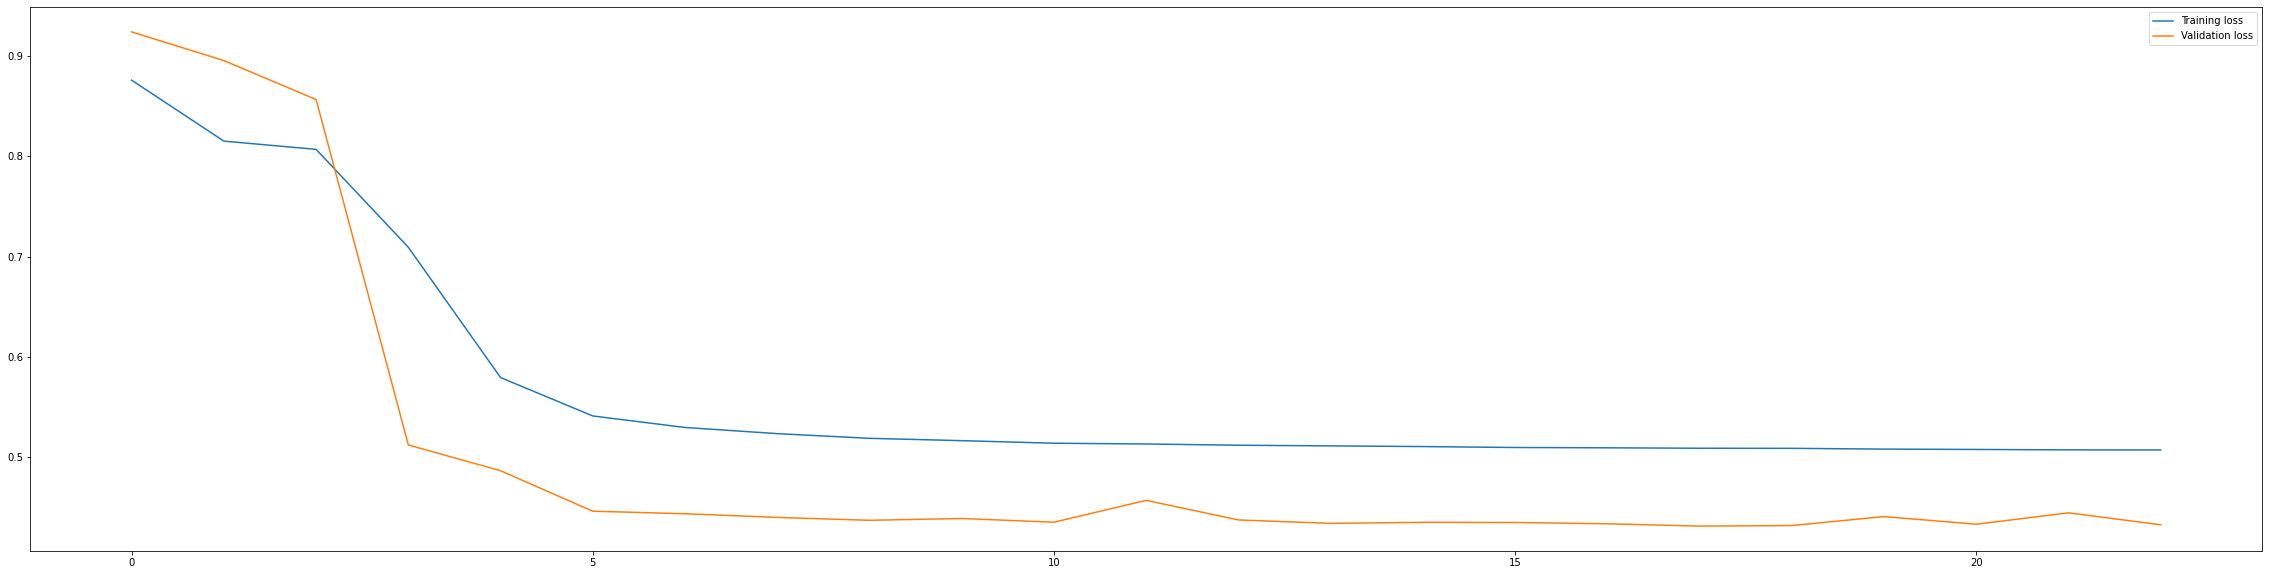

In [13]:
print('Train...')
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1, shuffle=True, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

# Plot the training and validation loss 
print("Graph Results...")
plt.figure(figsize=(40,10))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

487/487 [==============================] - 154s 314ms/step


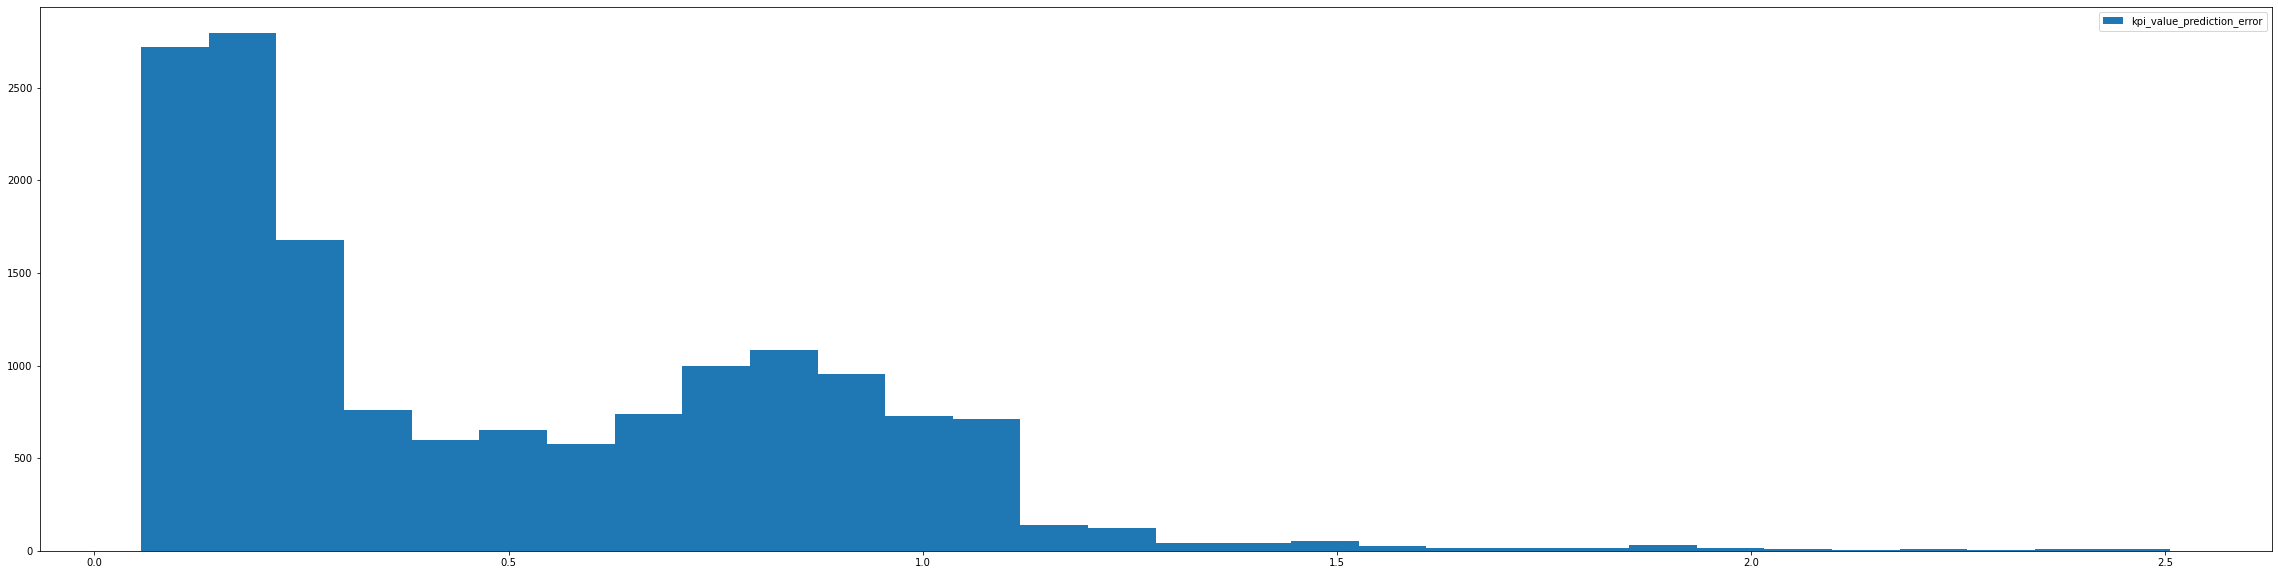

In [14]:
# Plot a histogram of the reconstruction error in the training dataset to decide a threshold

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(trainMAE, bins=30);
plt.legend(['kpi_value_prediction_error'])
threshold_trainMAE = 0.95 #or Define 90% value of max as threshold.

In [15]:
print(f"Train Predict Shape {trainPredict.shape[0]}")
print(f"Train Y Shape {trainY.shape[0]}")

Train Predict Shape 15567
Train Y Shape 15567


116/116 [==============================] - 30s 263ms/step


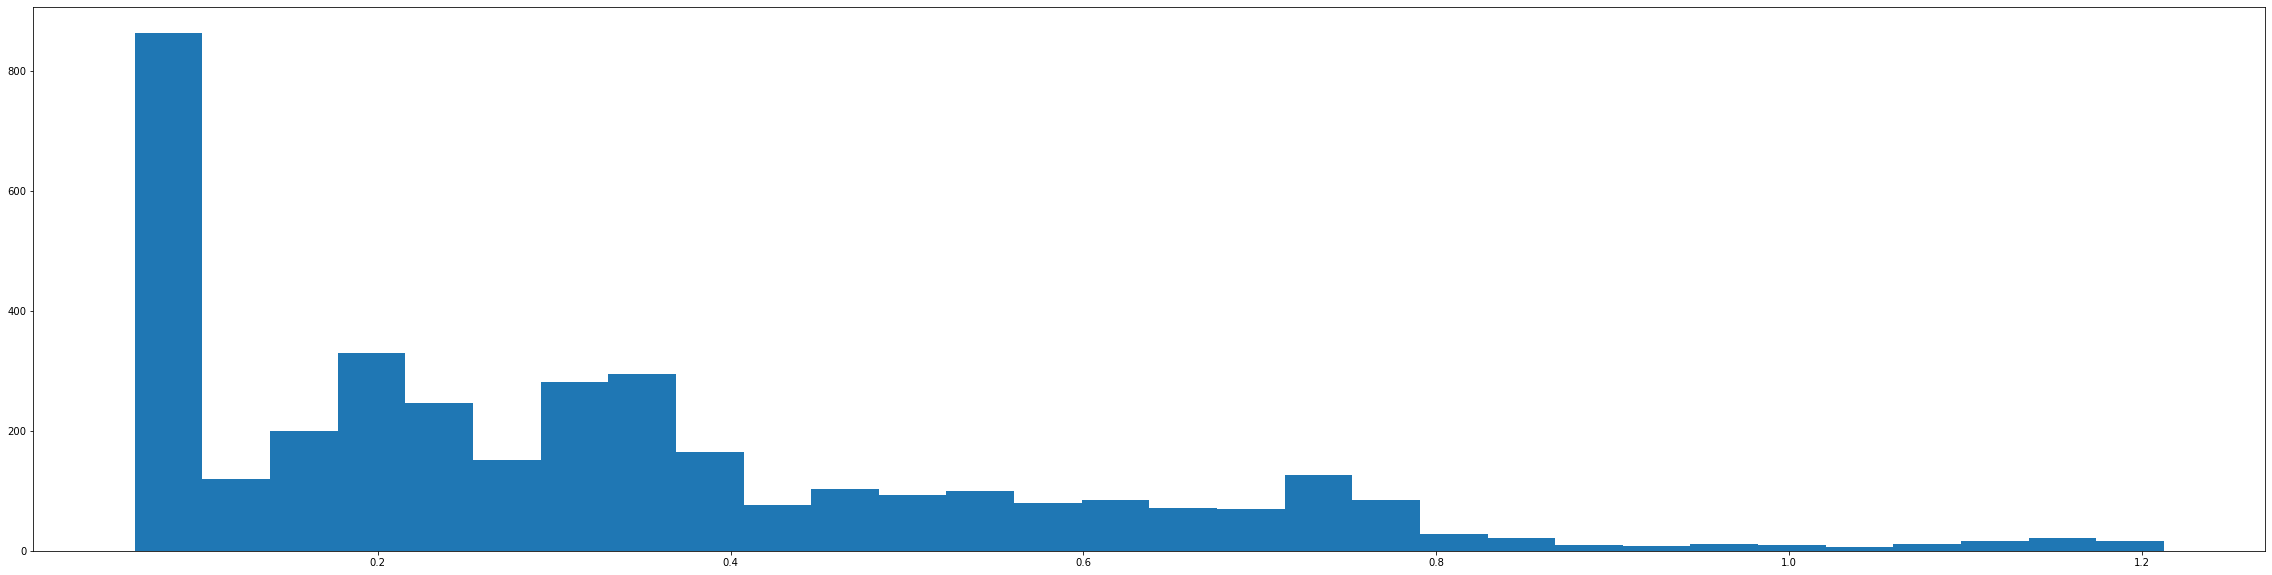

In [16]:
# Histogram of the testing MAE
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(testMAE, bins=30);

In [17]:
print(testPredict[0])
print("  ")
print(testY[0])
print("  ")
print(np.abs(testPredict[0]-testY[0]))

[[0.72328025]
 [0.638443  ]
 [0.6471036 ]
 [0.6372916 ]
 [0.6387965 ]
 [0.6612792 ]
 [0.66904974]
 [0.66461354]
 [0.7222915 ]
 [0.7276323 ]
 [0.7484386 ]
 [0.75532085]
 [0.7920492 ]
 [0.78346926]
 [0.78224504]
 [0.78619075]
 [0.8279352 ]
 [0.84883404]
 [0.85809696]
 [0.86510825]
 [0.8724839 ]
 [0.89689296]
 [0.89949566]
 [0.91285825]
 [0.94511694]
 [0.94586337]
 [0.96076804]
 [0.9608184 ]
 [0.9697948 ]
 [0.97899216]
 [0.99539375]
 [0.9915354 ]
 [1.0371358 ]
 [1.0409751 ]
 [1.0471847 ]
 [1.0599796 ]
 [1.0751721 ]
 [1.084847  ]
 [1.0858799 ]
 [1.0940188 ]
 [1.123442  ]
 [1.1347983 ]
 [1.1583034 ]
 [1.1546851 ]
 [1.1696695 ]
 [1.1812613 ]
 [1.1815746 ]
 [1.1800162 ]
 [1.2055222 ]
 [1.215007  ]
 [1.2274357 ]
 [1.2284981 ]
 [1.2323989 ]
 [1.2438376 ]
 [1.2400694 ]
 [1.2459117 ]
 [1.2597982 ]
 [1.2770739 ]
 [1.2723392 ]
 [1.277987  ]
 [1.2788976 ]
 [1.274521  ]
 [1.2707323 ]
 [1.2777802 ]
 [1.2968235 ]
 [1.3028115 ]
 [1.3114228 ]
 [1.3251301 ]
 [1.3273352 ]
 [1.3384852 ]
 [1.3453263 ]
 [1.34

In [18]:
# Detect anomaly if the reconstruction loss for a sample is greater than the threshold

anomaly_df = pd.concat([seq[TIME_STEPS:] for seq in testSeqs])
anomaly_df['testMAE'] = testMAE
anomaly_df['threshold_trainMAE'] = threshold_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['threshold_trainMAE']

In [19]:
testPredict.shape[0]

3696

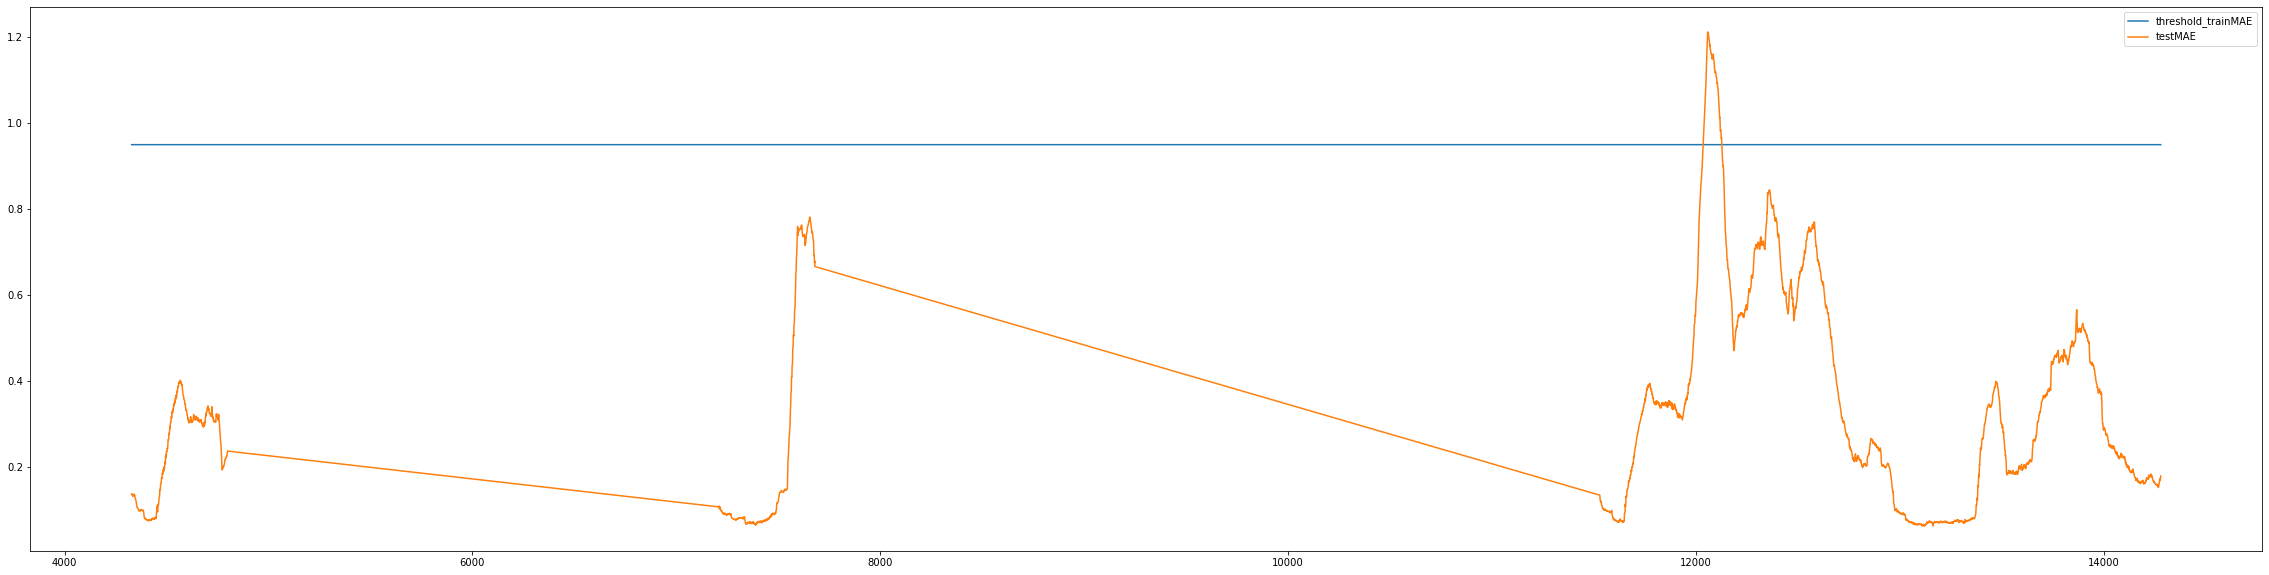

In [20]:
# Plot the test MAE
plt.figure(figsize=[40, 10])
anomaly_df['threshold_trainMAE'].plot()
anomaly_df['testMAE'].plot()
plt.legend()

In [21]:
# Detect the anomaly points inside the dataset
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

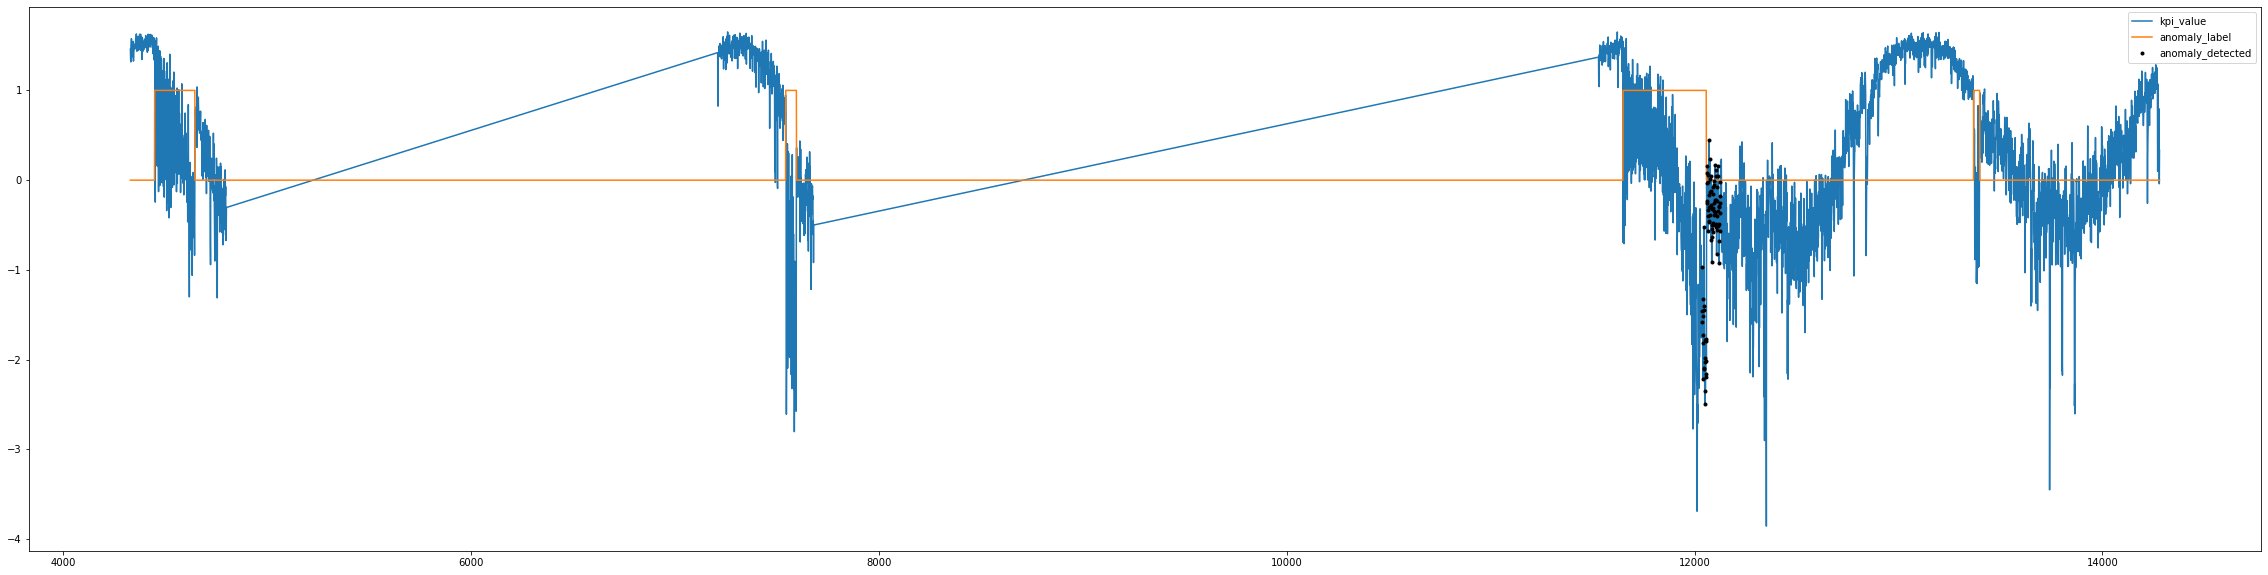

In [22]:
#Plot the anomalies
plt.figure(figsize=(40,10))
anomaly_df['kpi_value'].plot()
anomaly_df['anomaly_label'].plot()
anomalies['kpi_value'].plot(marker='.', linestyle='None', label='anomaly_detected', color='black')
plt.legend()

In [23]:
# Inspect the resulting dataset
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 4329 to 14280
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype                                
---  ------              --------------  -----                                
 0   timestamp           3696 non-null   datetime64[ns, pytz.FixedOffset(120)]
 1   kpi_value           3696 non-null   float64                              
 2   request_count       3696 non-null   float64                              
 3   anomaly_label       3696 non-null   int64                                
 4   testMAE             3696 non-null   float64                              
 5   threshold_trainMAE  3696 non-null   float64                              
 6   anomaly             3696 non-null   bool                                 
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(120)](1), float64(4), int64(1)
memory usage: 205.7 KB


In [24]:
anomaly_df

,timestamp,kpi_value,request_count,anomaly_label,testMAE,threshold_trainMAE,anomaly
4329,2020-08-17 02:09:00+02:00,1.459757,1.668797,0,0.137374,0.95,False
4330,2020-08-17 02:10:00+02:00,1.352807,1.710047,0,0.137713,0.95,False
4331,2020-08-17 02:11:00+02:00,1.317357,1.595159,0,0.135631,0.95,False
4332,2020-08-17 02:12:00+02:00,1.494109,1.595006,0,0.134011,0.95,False
4333,2020-08-17 02:13:00+02:00,1.546680,1.602798,0,0.133459,0.95,False
...,...,...,...,...,...,...,...
14276,2020-08-23 23:56:00+02:00,0.106058,1.186481,0,0.169226,0.95,False
14277,2020-08-23 23:57:00+02:00,0.795930,1.293424,0,0.168267,0.95,False
14278,2020-08-23 23:58:00+02:00,0.695386,1.230480,0,0.171568,0.95,False
14279,2020-08-23 23:59:00+02:00,-0.039992,1.115898,0,0.175766,0.95,False


In [25]:
# Compute the precision in the test dataset
precision=precision_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"Precision: {round(precision, 3)}")
# Compute the recall in the test dataset
recall=recall_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"Recall: {round(recall, 3)}")
# Compute the F1 score in the test dataset
f1_score=f1_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"F1 Score: {round(f1_score, 3)}")

Precision: 0.239
Recall: 0.032
F1 Score: 0.056
